- 이 파일 셀들을 복사해서 제출 notebook 만든다.
- 이 repo의 src, third-party, ckpt를 압축한다. 
  - ex) submission_files.zip
- 하나의 directory로 업로드 한다.
  - /kaggle/input/submission_files 로 올린다.
  - 압축 알아서 풀려있음

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import os
import random
import torch
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import argparse
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import sys
import pandas as pd
# 일단 __init__.py 추가해서 이렇게 해놨음.
BASE_PATH='/workspaces/kaggle-NFL-contact-detection'
sys.path.append(os.path.join(BASE_PATH, "src"))

# timm as third-party
sys.path.append(os.path.join(BASE_PATH, 'third-party/pytorch-image-models'))

from config import CFG
from factory.dataset_factory import DataSetFactory
from factory.lightning_module_factory import LightningModuleFactory
from train import seed_everything

In [22]:
# TODO: data dir train/pred 구분.
CFG["dataset_params"]["data_dir"] = os.path.join(BASE_PATH, "data")
CFG["dataset_params"]["preprocess_result_dir"] = os.path.join(BASE_PATH, "data/processed")
CFG["is_prediction"] = True
CFG["is_submission"] = True

In [23]:
seed_everything(CFG['seed'])
device_str = "cpu"
if torch.cuda.is_available():
    device_str = "cuda"
device_str

'cuda'

In [24]:
saved_model_path = os.path.join(
    BASE_PATH, 
    "epoch-9-step-39210-011916.ckpt"
)

In [25]:

model_name = f"{CFG['model_name']}-{CFG['model_version']}"
dataset_params = CFG['dataset_params']
model_params = CFG['model_params']
data_module = DataSetFactory.get_dataset(name=model_name,
                                            params=dataset_params)
lightning_module = LightningModuleFactory.get_lightning_module(name=model_name,
                                                                load_path=saved_model_path,
                                                                params=model_params)

trainer = pl.Trainer(max_epochs=CFG["epochs"],
                        accelerator=device_str,
                        devices=1 if device_str != "cpu" else None,
                        logger=False
                    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [22]:
predictions = trainer.predict(
    model=lightning_module, 
    datamodule=data_module)


====== [Preprocess] ======
- is_prediction: True
- run_type: test
------ [Loading Metadata] ------
------ [ffmpeg] ------
ffmpeg frames test


100%|██████████| 4/4 [00:00<00:00, 12096.05it/s]


------ [Mapping metadata] ------
Mapping video2helmets [size: 4]


100%|██████████| 4/4 [00:00<00:00, 347.48it/s]


-- Mapping video2frames: [size: 2]


100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


------ [Preprocess helmet sensor data] ------
Expand contact id
Create features


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


------ [Setup dataset] ------
====== Generating dataset  ======
- stage: predict
------ [Load metadata] ------
-- Label count predict: 
contact
0    6631
Name: contact, dtype: int64
- predict_dataset_size: 6631
Predicting DataLoader 0: 100%|██████████| 277/277 [00:56<00:00,  4.94it/s]


In [23]:
df_filtered = data_module.dataset_pred.df

In [24]:
y_pred = []
for p in predictions:
    y_pred += p.tolist() 
y_pred_np = np.array(y_pred)

In [25]:
len(y_pred_np), len(df_filtered)

(6631, 6631)

In [26]:
df_filtered['contact'] = (y_pred_np >= CFG["threshold"]).astype('int')
df_filtered.groupby("contact")["contact"].count()

contact
0    6171
1     460
Name: contact, dtype: int64

In [27]:

sub = pd.read_csv(os.path.join(CFG["dataset_params"]["data_dir"], 'sample_submission.csv'))

sub = sub.drop("contact", axis=1).merge(df_filtered[['contact_id', 'contact']], how='left', on='contact_id')
sub['contact'] = sub['contact'].fillna(0).astype('int')

sub[["contact_id", "contact"]].to_csv("submission.csv", index=False)

sub.head()

,contact_id,contact
0,58168_003392_0_38590_43854,0
1,58168_003392_0_38590_41257,0
2,58168_003392_0_38590_41944,0
3,58168_003392_0_38590_42386,0
4,58168_003392_0_38590_47944,0


In [28]:
# test for threshold

In [28]:
trainer.test(model=lightning_module, datamodule=data_module)

====== [Preprocess] ======
- is_prediction: True
- run_type: test
------ [Loading Metadata] ------
------ [ffmpeg] ------
ffmpeg frames test


100%|██████████| 4/4 [00:00<00:00, 13273.11it/s]


------ [Mapping metadata] ------
Mapping video2helmets [size: 4]


100%|██████████| 4/4 [00:00<00:00, 355.79it/s]


-- Mapping video2frames: [size: 2]


100%|██████████| 2/2 [00:00<00:00,  2.46it/s]


------ [Preprocess helmet sensor data] ------
Expand contact id
Create features
------ [Setup dataset] ------
====== Generating dataset  ======
- stage: test
------ [Load metadata] ------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


-- num_videos: 4/40
-- Label count test: 
contact
0    12752
1     1430
Name: contact, dtype: int64
- test_dataset_size: 14182
Testing DataLoader 0: 100%|██████████| 591/591 [01:57<00:00,  5.01it/s]====== [Test contact counts] ======
-- preds  : 810.0/14182
-- labels : 1430.0/14182

Testing DataLoader 0: 100%|██████████| 591/591 [01:57<00:00,  5.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_acc_step         0.8996615409851074
        test_loss           0.2559502124786377
        test_mcc            0.2929716110229492
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2559502124786377,
  'test_acc_step': 0.8996615409851074,
  'test_mcc': 0.2929716110229492}]

In [56]:
thresholds = np.arange(0.0,1.0, 0.001)
mccs = []
for threshold in thresholds:
    outputs_cat = torch.cat(trainer.model.last_test_output)
    y, labels = outputs_cat[:, 0], outputs_cat[:, 1]
    preds = (y > threshold).float()
    # print(
    #     f"====== [Test contact counts] ======\n"
    #     f"-- preds  : {torch.sum(preds)}/{len(preds)}\n"
    #     f"-- labels : {torch.sum(labels)}/{len(labels)}\n")
    mcc_loss = trainer.model.mcc_loss(preds, labels)
    mcc = 1.0 - mcc_loss
    # print(mcc.item())
    mccs.append(mcc.item())
mccs = np.array(mccs)

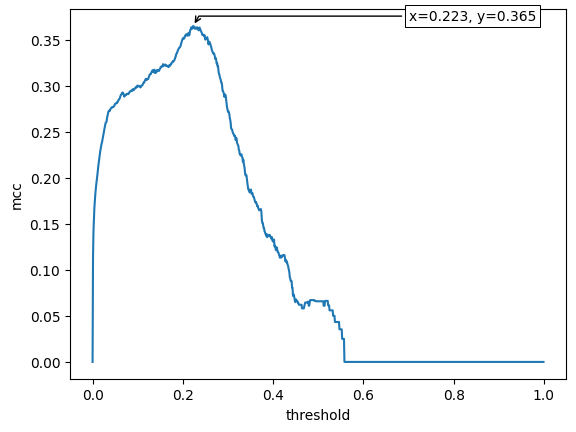

In [57]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(thresholds, mccs)
ax.set_xlabel("threshold")
ax.set_ylabel("mcc")

def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,1.00), **kw)
    

annot_max(thresholds, mccs)
plt.show()